In [1]:
# import libraries
import numpy as np
import pandas as pd
from scipy import stats
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
import sklearn.metrics as skm
import matplotlib.pyplot as plt
import seaborn as sns
import copy, time, matplotlib, sys

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, Dataset, Subset
from torchsummary import summary

import torchvision
import torchvision.transforms as T

import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
# plt.rcParams.update({'font.size':11})

In [2]:
# use GPU if available
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

# Project 1: Import and classify CIFAR10

## Import a dataset

In [3]:
# transformations
# can do any other transformations..? and data augmentation such as random rotations, changes color saturations...
transform = T.Compose([
    T.ToTensor(),
    T.Normalize([.5,.5,.5],[.5,.5,.5]) # range [0 255] -> [-1 1]
])

# import the data and simultaneously apply the transform
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
devtest = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# split the devtest into two separate sets
rand_idx = np.random.permutation(10000) # a random permutation of indices
valset = Subset(devtest, rand_idx[:6000]) # subset for valset
testset = Subset(devtest, rand_idx[6000:])

# transform to dataloader
batchsize=32
train_loader = DataLoader(trainset, batch_size=batchsize, shuffle=True, drop_last=True)
# facilitate memory usage a little bit
val_loader = DataLoader(valset, batch_size=batchsize, shuffle=True, drop_last=True) # note: val in batches!
test_loader = DataLoader(testset, batch_size=len(testset))

# check out the shape of the datasets
print('Data shapes (train/val/test):')
print(len(trainset))
print(len(valset))
print(len(testset))

# and the range of pixel intensity values
print('\nData value range:')
print( np.min(trainset.data), np.max(trainset.data) )

# the unique categories
print('\nData categories:')
print(trainset.classes)

100%|██████████| 170498071/170498071 [00:03<00:00, 43690207.06it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Data shapes (train/val/test):
50000
6000
4000

Data value range:
0 255

Data categories:
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [4]:
# Uh oh! It looks like the images are the wrong dimensions!
# They ned to be 3x32x32.
# And they are not normalized!

# but...
X, y = next(iter(train_loader))

# try again
print('Data shapes (train):')
print(X.data.shape)

# and the range of pixel intensity values
print('\nData value range:')
print( (torch.min(X.data), torch.max(X.data)) )

Data shapes (train):
torch.Size([32, 3, 32, 32])

Data value range:
(tensor(-1.), tensor(1.))


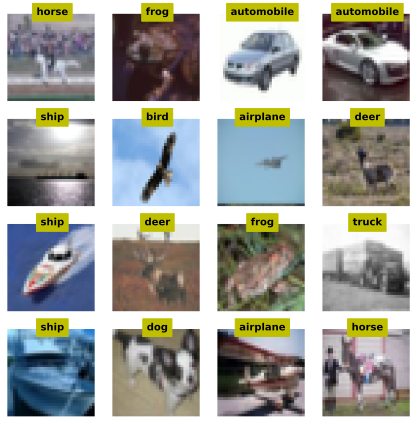

In [6]:
# inspect a few random images

fig, axs = plt.subplots(4,4,figsize=(6,6))

for (i, ax) in enumerate(axs.flatten()):

    # extract the image (need to transpose it back to 32x32x3)
    pic = X.data[i].numpy().transpose((1,2,0))
    pic = pic / 2 + .5 # undo normalization

    # and its label
    label = trainset.classes[y[i]]

    # and show!
    ax.imshow(pic)
    ax.text(16,0, label, ha='center', fontweight='bold', color='k', backgroundcolor='y')
    ax.axis('off')

plt.tight_layout()
plt.show()

## Create the DL model

In [7]:
def makeTheNet(print_toggle=False):

    class cnnnet(nn.Module):
        def __init__(self, print_toggle):
            super().__init__()

            # print toggle
            self.print = print_toggle

            # ------------------------- feature map layers ------------------------- #
            # first convolution layer
            self.conv1 = nn.Conv2d(3,64,3,padding=1)
            self.bnorm1 = nn.BatchNorm2d(64)               # input the number of channels in this layer
            # output size: (32 + 2*1 -3)/1 + 1 = 32 / 2 = 16 (maxpool)

            # second convolution layer
            self.conv2 = nn.Conv2d(64, 128, 3)
            self.bnorm2 = nn.BatchNorm2d(128)             # input the number of channels in this layer
            # output size: (16 + 2*0 - 3)/1 + 1 = 14 / 2 = 7 (maxpool)

            # thrid convolution layer
            self.conv3 = nn.Conv2d(128, 256, 3)
            self.bnorm3 = nn.BatchNorm2d(256)             # input the number of channels in this layer
            # output size: (7 + 2*0 - 3)/1 + 1 = 5 / 2 = 2 (maxpool)

            # ------------------------- linear decision layers ------------------------- #
            self.fc1 = nn.Linear(2*2*256, 256)
            self.fc2 = nn.Linear(256, 64)
            self.fc3 = nn.Linear(64, 10)

        def forward(self, x):

            if self.print: print(f'Input: {list(x.shape)}')

            # first block: convolution -> maxpool -> batchnorm -> relu
            x = F.max_pool2d(self.conv1(x), 2)
            x = F.leaky_relu(self.bnorm1(x))
            if self.print: print(f'First block: {list(x.shape)}')

            # second block: convolution -> maxpool -> batchnorm -> relu
            x = F.max_pool2d(self.conv2(x), 2)
            x = F.leaky_relu(self.bnorm2(x))
            if self.print: print(f'Second block: {list(x.shape)}')

            # third block: convolution -> maxpool -> batchnorm -> relu
            x = F.max_pool2d(self.conv3(x), 2)
            x = F.leaky_relu(self.bnorm3(x))
            if self.print: print(f'Third block: {list(x.shape)}')

            # reshape for linear layer
            nUnits = x.shape.numel() / x.shape[0]
            x = x.view(-1, int(nUnits))
            if self.print: print(f'Vectorized: {list(x.shape)}')

            # linear layers
            x = F.leaky_relu(self.fc1(x))
            x = F.dropout(x, p=.5, training=self.training)
            x = F.leaky_relu(self.fc2(x))
            x = F.dropout(x, p=.5, training=self.training) # training = self.training means to turn off during eval mode
            x = self.fc3(x)

            if self.print: print(f'Final output: {list(x.shape)}')

            return x

    net = cnnnet(print_toggle)
    lossfunc = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=.001, weight_decay=1e-5)

    return net, lossfunc, optimizer

In [ ]:
### TESTING some other model architectures...

# # create a class for the model
# def makeTheNet(printtoggle=False):

#   class cnnnet(nn.Module):
#     def __init__(self,printtoggle):
#       super().__init__()

#       # print toggle
#       self.print = printtoggle

#       ### -------------- encoding layers -------------- ###
#       # first convolution layer
#       self.encconv1  = nn.Conv2d(3,16,4,padding=1,stride=2) # note: using stride instead of pool to downsample
#       # output size: (28+2*1-4)/2 + 1 = 14

#       # second convolution layer
#       self.encconv2  = nn.Conv2d(16,32,4,padding=1,stride=2)
#       # output size: (14+2*1-4)/2 + 1 = 7

#       # third convolution layer
#       self.encconv3  = nn.Conv2d(32,64,4,padding=1,stride=2)
#       # output size: (7+2*1-4)/2 + 1 = 4



#       ### ------------- linear layers ------------- ###
#       self.fc1  = nn.Linear(4*4*64,128)
#       self.fc2  = nn.Linear(128,64)
#       self.fc3  = nn.Linear(64,10)


#     def forward(self,x):

#       if self.print: print(f'Input: {list(x.shape)}')

#       # first encoder layer
#       x = F.leaky_relu(self.encconv1(x))
#       if self.print: print(f'First encoder layer: {list(x.shape)}')

#       # second encoder layer
#       x = F.leaky_relu(self.encconv2(x))
#       if self.print: print(f'Second encoder layer: {list(x.shape)}')

#       # third encoder layer
#       x = F.leaky_relu(self.encconv3(x))
#       if self.print: print(f'Third encoder layer: {list(x.shape)}')

#       # reshape to linear
#       nUnits = x.shape.numel()/x.shape[0]
#       x = x.view(-1,int(nUnits))
#       if self.print: print(f'Post-convolution vectorized: {list(x.shape)}')

#       # linear layers
#       x = F.leaky_relu(self.fc1(x))
#       if self.print: print(f'First linear layer: {list(x.shape)}')

#       x = F.leaky_relu(self.fc2(x))
#       if self.print: print(f'Second linear layer: {list(x.shape)}')

#       x = F.leaky_relu(self.fc3(x))
#       if self.print: print(f'Output linear layer: {list(x.shape)}')

#       return x

#   # create the model instance
#   net = cnnnet(printtoggle)

#   # loss function
#   lossfun = nn.CrossEntropyLoss()

#   # optimizer
#   optimizer = torch.optim.Adam(net.parameters(),lr=.001)

#   return net,lossfun,optimizer

In [8]:
# test the model with one batch
net, lossfunc, optimizer = makeTheNet(True)

X, y = next(iter(train_loader))
yHat = net(X)

# check size of output
print('Output size:')
print(yHat.shape)

# compute the loss
loss = lossfunc(yHat, torch.squeeze(y))
print('\nLoss:')
print(loss)

Input: [32, 3, 32, 32]
First block: [32, 64, 16, 16]
Second block: [32, 128, 7, 7]
Third block: [32, 256, 2, 2]
Vectorized: [32, 1024]
Final output: [32, 10]
Output size:
torch.Size([32, 10])

Loss:
tensor(2.2984, grad_fn=<NllLossBackward0>)


## Create a function that trains the model

In [9]:
def function2trainTheModel():

    numepochs = 10

    net, lossfunc, optimizer = makeTheNet()

    net.to(device)

    trainLoss = torch.zeros(numepochs)
    valLoss = torch.zeros(numepochs)
    trainAcc = torch.zeros(numepochs)
    valAcc = torch.zeros(numepochs)

    for epochi in range(numepochs):

        net.train()
        batchLoss = []
        batchAcc = []
        for X, y in train_loader:
            X = X.to(device)
            y = y.to(device)

            yHat = net(X)
            loss = lossfunc(yHat, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            batchLoss.append(loss.item())
            batchAcc.append( 100 * torch.mean((torch.argmax(yHat, axis=1)==y).float()).item() )

        trainAcc[epochi] = np.mean(batchAcc)
        trainLoss[epochi] = np.mean(batchLoss)

        # test performance (here done in batches!)
        net.eval()
        batchAcc = []
        batchLoss = []

        for X, y in val_loader:
            X = X.to(device)
            y = y.to(device)

            with torch.no_grad():
                yHat = net(X)
                loss = lossfunc(yHat, y)

            batchLoss.append(loss.item())
            batchAcc.append( 100 * torch.mean((torch.argmax(yHat, axis=1)==y).float()).item() )

        valLoss[epochi] = np.mean(batchLoss)
        valAcc[epochi] = np.mean(batchAcc)

    return trainLoss, valLoss, trainAcc, valAcc, net

## Run the model and show the results!

In [10]:
trainLoss, valLoss, trainAcc, valAcc, net = function2trainTheModel()

In [11]:
# the real test set!

net.eval()
X, y = next(iter(test_loader))

X = X.to(device)
y = y.to(device)

with torch.no_grad():
    yHat = net(X)
    loss = lossfunc(yHat, y)

testLoss = loss.item()
testAcc = 100 * torch.mean((torch.argmax(yHat, axis=1)==y).float()).item()

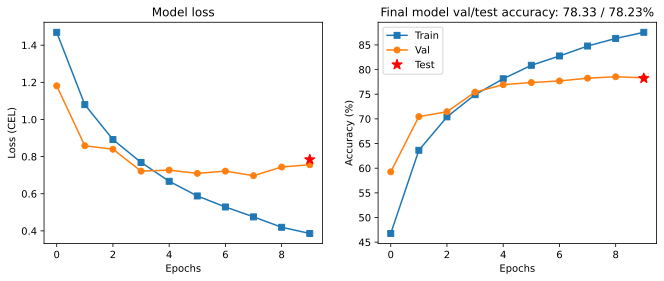

In [12]:
fig, ax = plt.subplots(1,2,figsize=(11,4))

ax[0].plot(trainLoss, 's-', label='Train')
ax[0].plot(valLoss, 'o-', label='Val')
ax[0].plot(len(valLoss)-1, testLoss, 'r*', markersize=11, label='Test')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss (CEL)')
ax[0].set_title('Model loss')

ax[1].plot(trainAcc, 's-', label='Train')
ax[1].plot(valAcc, 'o-', label='Val')
ax[1].plot(len(valAcc)-1, testAcc, 'r*', markersize=11, label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_title(f'Final model val/test accuracy: {valAcc[-1]:.2f} / {testAcc:.2f}%')
ax[1].legend()

plt.show()

# Project 2: CIFAR-autoencoder

## Import the CIFAR dataset

In [13]:
# transformations
transform = T.Compose([
    T.ToTensor(),
    T.Normalize([.5,.5,.5],[.5,.5,.5])
])

# import the data and simultaneously apply the transform
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# transform to dataloaders
batchsize=32
train_loader = DataLoader(trainset, batch_size=batchsize, shuffle=True, drop_last=True)
test_loader = DataLoader(testset, batch_size=256)

Files already downloaded and verified
Files already downloaded and verified


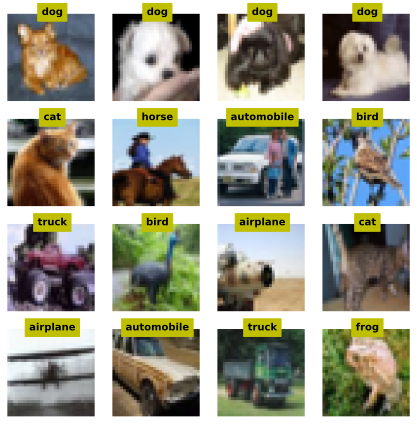

In [15]:
# inspect a few random images
X, y = next(iter(train_loader))

fig, axs = plt.subplots(4,4,figsize=(6,6))

for (i, ax) in enumerate(axs.flatten()):

    # extract that images
    pic =X.data[i].numpy().transpose((1,2,0))
    pic = pic/2 + .5 # undo normalization

    # and its label
    label = trainset.classes[y[i]]

    # and show!
    ax.imshow(pic)
    ax.text(16,0, label, ha='center', fontweight='bold', color='k', backgroundcolor='y')
    ax.axis('off')

plt.tight_layout()
plt.show()

## Create the CNN-AE model

In [20]:
def makeTheAENet(print_toggle=False):

    class aenet(nn.Module):
        def __init__(self, print_toggle):
            super().__init__()

            # print toggle
            self.print = print_toggle

            # ------------------------------ encoding layers ------------------------------ #
            # first convolution layer
            self.enc_conv1 = nn.Conv2d(3,16,4,padding=1, stride=2) # note: using stride instead of pool to downsample
            # output size: (32 + 2*1 - 4)/2 + 1 = 16

            # second convolution layer
            self.enc_conv2 = nn.Conv2d(16,32,4,padding=1, stride=2)
            # output size: (16 + 2*1 - 4)/2 + 1 = 8

            # third convolution layer (latent code layer)
            self.latent = nn.Conv2d(32,64,4, padding=1, stride=2)
            # output size: (8 + 2*1 - 4)/2 + 1 = 4

            # ------------------------------ decoding layers ------------------------------ #
            # first convolution layer
            self.dec_conv1 = nn.ConvTranspose2d(64,32,4,padding=1, stride=2)

            # second convolution layer
            self.dec_conv2 = nn.ConvTranspose2d(32,16,4, padding=1, stride=2)

            # third convolution layer (output)
            self.output = nn.ConvTranspose2d(16,3,4,padding=1, stride=2)

        def forward(self, x):

            if self.print: print(f'Input: {list(x.shape)}')

            # first encoder block
            x = F.leaky_relu( self.enc_conv1(x) )
            if self.print: print(f'First encoder block: {list(x.shape)}')

            # second encoder block
            x = F.leaky_relu( self.enc_conv2(x) )
            if self.print: print(f'Second encoder block: {list(x.shape)}')

            # latent block
            x = F.leaky_relu( self.latent(x) )
            if self.print: print(f'Latent layer: {list(x.shape)}')

            # first decoder block
            x = F.leaky_relu( self.dec_conv1(x) )
            if self.print: print(f'First decoder block: {list(x.shape)}')

            # second decoder block
            x = F.leaky_relu( self.dec_conv2(x) )
            if self.print: print(f'Second decoder block: {list(x.shape)}')

            # output block
            x = F.leaky_relu( self.output(x) )
            if self.print: print(f'Decoder output: {list(x.shape)}')

            return x

    net = aenet(print_toggle)
    lossfunc = nn.MSELoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=.001, weight_decay=1e-5)

    return net, lossfunc, optimizer

In [21]:
# test the model with one batch
aenet, lossfunc, optimizer = makeTheAENet(True)

X, y = next(iter(train_loader))
yHat = aenet(X)

loss = lossfunc(yHat, X)

print(yHat.shape)
print('\nLoss:')
print(loss)

Input: [32, 3, 32, 32]
First encoder block: [32, 16, 16, 16]
Second encoder block: [32, 32, 8, 8]
Latent layer: [32, 64, 4, 4]
First decoder block: [32, 32, 8, 8]
Second decoder block: [32, 16, 16, 16]
Decoder output: [32, 3, 32, 32]
torch.Size([32, 3, 32, 32])

Loss:
tensor(0.2728, grad_fn=<MseLossBackward0>)


## Create a function that trains the AE model

In [22]:
def function2trainTheAEModel(net, lossfunc, optimizer):

    numepochs = 20

    net.to(device)

    trainLoss = torch.zeros(numepochs)
    testLoss = torch.zeros(numepochs)

    for epochi in range(numepochs):

        net.train()
        batchLoss = []

        for X, _ in train_loader:
            X = X.to(device)

            yHat = net(X)
            loss = lossfunc(yHat, X)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            batchLoss.append(loss.item())

        trainLoss[epochi] = np.mean(batchLoss)

        net.eval()
        batchLoss = []

        for X, _ in test_loader:
            X = X.to(device)

            yHat = net(X)
            loss = lossfunc(yHat, X)

            batchLoss.append(loss.item())

        testLoss[epochi] = np.mean(batchLoss)

    return trainLoss, testLoss, net

## Run the AE model and show the results!

In [24]:
# ~5 minutes with 15 epochs on GPU

# createa new model
netAE, lossfunc, optimizer = makeTheAENet()

trainLossAE, testLossAE, netAE = function2trainTheAEModel(netAE, lossfunc, optimizer)

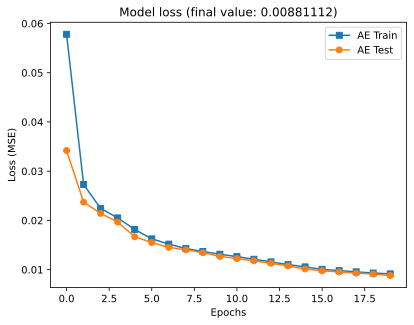

In [25]:
plt.plot(trainLossAE, 's-', label='AE Train')
plt.plot(testLossAE, 'o-', label='AE Test')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.title('Model loss (final value: %g)' %testLossAE[-1])
plt.legend()

plt.show()

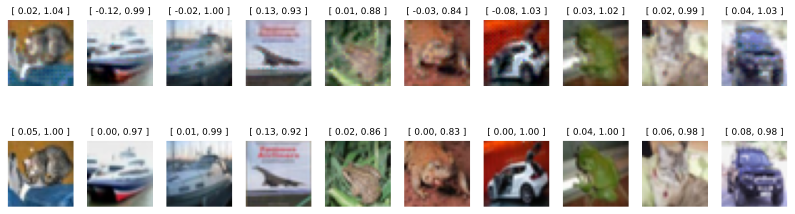

In [26]:
# show some random examples

# get some data
X, _ = next(iter(test_loader))

# forward pass and loss
netAE.cpu()
netAE.eval()
yHat = netAE(X)

fig, axs = plt.subplots(2,10,figsize=(14,4))

for i in range(10):
    pic = yHat[i, :,:,:].detach().numpy().transpose((1,2,0))
    pic = pic/2 + .5
    axs[0,i].imshow(pic)
    axs[0,i].set_title(f'[ {np.min(pic):.2f}, {np.max(pic):.2f} ]', fontsize=9)
    axs[0,i].axis('off')

    pic = X[i,:,:,:].detach().numpy().transpose((1,2,0))
    pic = pic/2 + .5
    axs[1,i].imshow(pic)
    axs[1,i].set_title(f'[ {np.min(pic):.2f}, {np.max(pic):.2f} ]', fontsize=9)
    axs[1,i].axis('off')

plt.show()

# Project 3: Import and classify FMNIST

## Import a dataset

In [3]:
# transformations
transform = T.Compose([
    T.ToTensor(),
    T.RandomHorizontalFlip(p=.5),
    T.Normalize(.5,.5),
])

# import the data and simultaneously apply the transform
trainset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
valtest = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

# split the valtest into two separate sets
rand_idx = np.random.permutation(10000) # random permutation of indices
valset = Subset(valtest, rand_idx[:6000]) # Subset for valset
testset = Subset(valtest, rand_idx[6000:]) # Subset for testset

# transform to dataloaders
batchsize=32
train_loader = DataLoader(trainset, batch_size=batchsize, shuffle=True, drop_last=True)
val_loader = DataLoader(valset, batch_size=len(valset))
test_loader = DataLoader(testset, batch_size=len(testset))

# check out the shape of the datasets
print('Data shapes (train/val/test):')
print(len(trainset))
print(len(valset))
print(len(testset))

100%|██████████| 26421880/26421880 [00:02<00:00, 11335835.70it/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 199936.82it/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3752130.46it/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 16320693.12it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw

Data shapes (train/val/test):
60000
6000
4000


In [4]:
# and the range of pixel intensity values
print('\nData value range:')
print( (torch.min(trainset.data), torch.max(trainset.data)) )

# the unique categories
print('\nData categories:')
print(trainset.classes)


Data value range:
(tensor(0, dtype=torch.uint8), tensor(255, dtype=torch.uint8))

Data categories:
['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


In [5]:
# Uh oh! It looks like the images are the wrong dimensions!
# They need to be 1x28x28
# And they are not normalized!

# but...
X, y = next(iter(train_loader))

# try again
print('Data shapes:')
print(X.data.shape)

# and the range of pixel intensity values
print('\nData value range:')
print( (torch.min(X.data), torch.max(X.data)) )

Data shapes:
torch.Size([32, 1, 28, 28])

Data value range:
(tensor(-1.), tensor(1.))


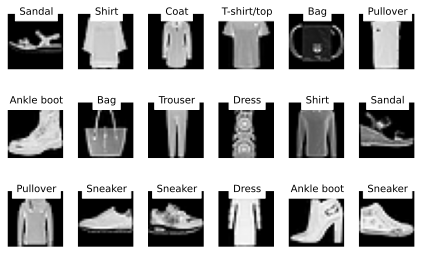

In [6]:
# inspect a few random images
fig, axs = plt.subplots(3,6,figsize=(6,4))

for (i, ax) in enumerate(axs.flatten()):

    # extract that image
    pic = torch.squeeze(X.data[i])
    pic = pic/2 + .5

    label = trainset.classes[y[i]]

    ax.imshow(pic, cmap='gray')
    ax.text(14,0, label, ha='center', color='k', backgroundcolor='w')
    ax.axis('off')

plt.tight_layout()
plt.show()

## Create the DL model

In [7]:
def makeTheNet(print_toggle=False):

    class cnnnet(nn.Module):
        def __init__(self, print_toggle):
            super().__init__()

            self.print = print_toggle

            # ---------------------- feature map layers ---------------------- #
            # first convolution layer
            self.conv1 = nn.Conv2d(1,16,3,padding=1)
            self.bnorm1 = nn.BatchNorm2d(16)
            # output size: (28 + 2*1 - 3)/1 + 1 = 28 / 2 = 14

            # second convolution layer
            self.conv2 = nn.Conv2d(16, 32, 3)
            self.bnorm2 = nn.BatchNorm2d(32)
            # outout size: (14 + 2*0 - 3)/1 + 1 = 12 / 2 = 6

            # ---------------------- linear decision layers ---------------------- #
            self.fc1 = nn.Linear(6*6*32, 64)
            self.fc2 = nn.Linear(64, 32)
            self.fc3 = nn.Linear(32, 10)

        def forward(self, x):

            if self.print: print(f'Input: {list(x.shape)}')

            # first block: convolution -> maxpool -> batchnorm -> relu
            x = F.max_pool2d(self.conv1(x), 2)
            x = F.leaky_relu(self.bnorm1(x))
            if self.print: print(f'First block: {list(x.shape)}')

            # second block: convolution -> maxpool -> batchnorm -> relu
            x = F.max_pool2d(self.conv2(x), 2)
            x = F.leaky_relu(self.bnorm2(x))
            if self.print: print(f'Second block: {list(x.shape)}')

            # reshape for linear layer
            nUnits = x.shape.numel() / x.shape[0]
            x = x.view(-1, int(nUnits))
            if self.print: print(f'Vectorized: {list(x.shape)}')

            # linear layers
            x = F.leaky_relu(self.fc1(x))
            x = F.dropout(x, p=.5, training=self.training)
            x = F.leaky_relu(self.fc2(x))
            x = F.dropout(x, p=.5, training=self.training)
            x = self.fc3(x)
            if self.print: print(f'Final output: {list(x.shape)}')

            return x

    net = cnnnet(print_toggle)
    lossfunc = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=.001)

    return net, lossfunc, optimizer

In [8]:
# test the model with one batch
net, lossfunc, optimizer = makeTheNet(True)

X, y = next(iter(train_loader))
yHat = net(X)

# check size of output
print('\nOutput size:')
print(yHat.shape)

# compute the loss
loss = lossfunc(yHat, torch.squeeze(y))
print('\nLoss:')
print(loss)

Input: [32, 1, 28, 28]
First block: [32, 16, 14, 14]
Second block: [32, 32, 6, 6]
Vectorized: [32, 1152]
Final output: [32, 10]

Output size:
torch.Size([32, 10])

Loss:
tensor(2.3291, grad_fn=<NllLossBackward0>)


## Create a funciton that trains the model

In [9]:
def function2trainTheModel():

    numepochs = 10

    net, lossfunc, optimizer = makeTheNet()

    net.to(device)

    trainLoss = torch.zeros(numepochs)
    valLoss = torch.zeros(numepochs)
    trainAcc = torch.zeros(numepochs)
    valAcc = torch.zeros(numepochs)

    for epochi in range(numepochs):

        net.train()
        batchLoss = []
        batchAcc = []
        for X, y in train_loader:
            X = X.to(device)
            y = y.to(device)

            yHat = net(X)
            loss = lossfunc(yHat, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            batchLoss.append(loss.item())
            batchAcc.append( 100 * torch.mean((torch.argmax(yHat, axis=1)==y).float()).item() )

        trainAcc[epochi] = np.mean(batchAcc)
        trainLoss[epochi] = np.mean(batchLoss)

        net.eval()
        X, y = next(iter(val_loader))
        X = X.to(device)
        y = y.to(device)

        with torch.no_grad():
            yHat = net(X)
            loss = lossfunc(yHat, y)

        valAcc[epochi] = 100 * torch.mean((torch.argmax(yHat, axis=1)==y).float()).item()
        valLoss[epochi] = loss.item()

    return trainLoss, valLoss, trainAcc, valAcc, net

## Run the model and show the results!

In [10]:
# ~3 minutes with 10 epochs on GPU
trainLoss, valLoss, trainAcc, valAcc, net = function2trainTheModel()

In [11]:
# the real test set!
net.eval()
X, y = next(iter(test_loader))

X = X.to(device)
y = y.to(device)

with torch.no_grad():
    yHat = net(X)
    loss = lossfunc(yHat, y)

testLoss = loss.item()
testAcc = 100 * torch.mean((torch.argmax(yHat, axis=1)==y).float()).item()

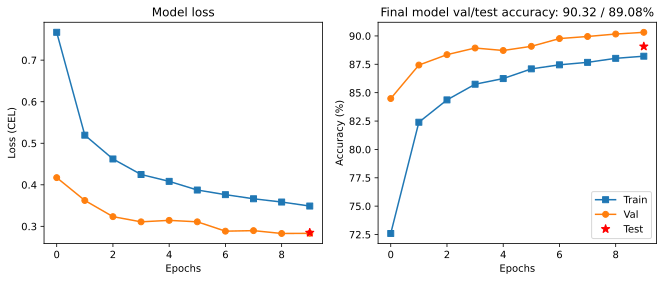

In [12]:
fig, ax = plt.subplots(1,2,figsize=(11,4))

ax[0].plot(trainLoss, 's-', label='Train')
ax[0].plot(valLoss, 'o-', label='Val')
ax[0].plot(len(valLoss)-1, testLoss, 'r*', markersize=9, label='Test')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss (CEL)')
ax[0].set_title('Model loss')

ax[1].plot(trainAcc, 's-', label='Train')
ax[1].plot(valAcc, 'o-', label='Val')
ax[1].plot(len(valAcc)-1, testAcc, 'r*', markersize=9, label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_title(f'Final model val/test accuracy: {valAcc[-1]:.2f} / {testAcc:.2f}%')
ax[1].legend()

plt.show()